In [3]:
# Complete Speech Emotion Recognition Pipeline (Single Cell)
# No per‐epoch prints of loss/accuracy — training runs silently.

# 0. Setup & Imports
import os
import warnings
import timeit
import multiprocessing as mp
import numpy as np
import pandas as pd
import librosa, librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from joblib import Parallel, delayed
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, Dropout,
    Flatten, Dense
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
)

warnings.simplefilter("ignore")
print("CPUs available:", mp.cpu_count())

CPUs available: 4


In [4]:
# 1. Paths to audio datasets
ravdess_path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
crema_path  = "/kaggle/input/cremad/AudioWAV/"
tess_path   = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
savee_path  = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"


In [5]:
# 2. Load & parse each dataset
def load_dataset(base_path, parser):
    records = []
    for entry in os.listdir(base_path):
        records.extend(parser(base_path, entry))
    return pd.DataFrame(records)

def parse_ravdess(base, actor):
    recs = []
    dirpath = os.path.join(base, actor)
    for fname in os.listdir(dirpath):
        code = fname.split('-')[2]
        label = {
            '01':'neutral','02':'calm','03':'happy','04':'sad',
            '05':'angry','06':'fearful','07':'disgust','08':'surprised'
        }[code].lower()
        recs.append({'Path': os.path.join(dirpath, fname), 'Emotion': label})
    return recs

ravdess_df = load_dataset(ravdess_path, parse_ravdess)

def parse_crema(base, fname):
    lab = fname.split('_')[2]
    label = {'SAD':'sad','ANG':'angry','DIS':'disgust',
             'FEA':'fearful','HAP':'happy','NEU':'neutral'}.get(lab, 'unknown').lower()
    return [{'Path': os.path.join(base, fname), 'Emotion': label}]

crema_df = load_dataset(crema_path, parse_crema)

def parse_tess(base, actor):
    recs = []
    dirpath = os.path.join(base, actor)
    for fname in os.listdir(dirpath):
        lab = fname.split('_')[2].lower()
        label = 'surprised' if lab=='ps' else lab
        recs.append({'Path': os.path.join(dirpath, fname), 'Emotion': label})
    return recs

tess_df = load_dataset(tess_path, parse_tess)

def parse_savee(base, fname):
    ele = fname.split('_')[1][:-6]
    label = {'a':'angry','d':'disgust','f':'fearful',
             'h':'happy','n':'neutral','sa':'sad'}.get(ele, 'surprised')
    return [{'Path': os.path.join(base, fname), 'Emotion': label}]

savee_df = load_dataset(savee_path, parse_savee)

Total samples: 12162


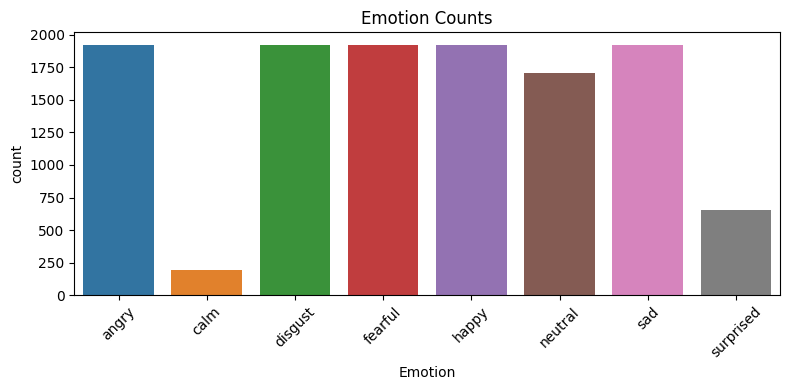

In [6]:
# 3. Combine, clean & inspect
data_path = pd.concat([ravdess_df, crema_df, tess_df, savee_df], ignore_index=True)
data_path['Emotion'] = data_path['Emotion'].str.replace(r"\.wav$", "", regex=True)
data_path['Emotion'] = data_path['Emotion'].replace({
    'fear':'fearful','ps':'surprised','pleasantsurprise':'surprised'
})
data_path = shuffle(data_path, random_state=42).reset_index(drop=True)

print("Total samples:", len(data_path))
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=data_path, order=sorted(data_path.Emotion.unique()))
plt.title("Emotion Counts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# 4. Augmentation functions
def add_noise(x): return x + 0.035*np.random.uniform()*np.amax(x)*np.random.normal(size=x.shape)
def stretch(x, rate=0.8): return librosa.effects.time_stretch(y=x, rate=rate)
def shift(x): return np.roll(x, int(np.random.uniform(-5,5)*1000))
def pitch(x, sr, n_steps=0.7): return librosa.effects.pitch_shift(y=x, sr=sr, n_steps=n_steps)

In [8]:
# 5. Fixed-length feature extractor
n_mfcc, max_frames = 40, 100
def pad_truncate(feat, max_len):
    return (np.pad(feat, ((0,0),(0,max_len-feat.shape[1])), mode='constant')
            if feat.shape[1]<max_len else feat[:,:max_len])

def extract_features_fixed(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = pad_truncate(mfcc, max_frames)
    mfcc = (mfcc - mfcc.mean())/(mfcc.std()+1e-6)
    z = pad_truncate(librosa.feature.zero_crossing_rate(y=y), max_frames)
    r = pad_truncate(librosa.feature.rms(y=y), max_frames)
    stacked = np.vstack((mfcc, z, r))
    return stacked.flatten()

def get_features(path):
    y, sr = librosa.load(path, duration=2.5, offset=0.6)
    out = [extract_features_fixed(y, sr)]
    for fn in (add_noise, lambda x: stretch(x,0.8), shift, lambda x: pitch(x, sr, 0.7)):
        out.append(extract_features_fixed(fn(y), sr))
    return np.stack(out, axis=0)

In [9]:
# 6. Parallel feature computation
start = timeit.default_timer()
results = Parallel(n_jobs=-1)(delayed(get_features)(p) for p in data_path.Path)
print("Feature extraction time:", timeit.default_timer() - start)

Feature extraction time: 657.5987251470001


In [10]:
# 7. Assemble X, Y
X, Y = [], []
for feats, emo in zip(results, data_path.Emotion):
    for vec in feats:
        X.append(vec)
        Y.append(emo)
X = np.vstack(X)
Y = np.array(Y)
print("Feature array shape:", X.shape)

Feature array shape: (60810, 4200)


In [ ]:
# 8. Preprocess & split into Train/Val/Test (90/5/5)
scaler  = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
encoder = OneHotEncoder(sparse=False).fit(Y.reshape(-1,1))
Y_enc = encoder.transform(Y.reshape(-1,1))

# 8.1 → split off 90% train vs. 10% hold-out
x_train_full, x_hold, y_train_full, y_hold = train_test_split(
    X_scaled, Y_enc,
    test_size=0.10,            # UPDATED
    random_state=42,
    stratify=np.argmax(Y_enc, axis=1)
)

# 8.2 → split 10% hold-out into 50/50 val & test (≈5% each)
x_val, x_test, y_val, y_test = train_test_split(
    x_hold, y_hold,
    test_size=0.50,            # UPDATED
    random_state=42,
    stratify=np.argmax(y_hold, axis=1)
)

# reshape for Conv1D
x_tr_cnn  = x_train_full[..., np.newaxis]
x_val_cnn = x_val[...,         np.newaxis]
x_te_cnn  = x_test[...,        np.newaxis]
print("Train / Val / Test shapes:", x_tr_cnn.shape, x_val_cnn.shape, x_te_cnn.shape)


In [ ]:
from tensorflow.keras.callbacks import Callback

# 9. Epoch-detail logger callback
class EpochDetailLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        l = logs or {}
        print(f"Epoch {epoch+1} -> loss: {l['loss']:.4f}, acc: {l['accuracy']:.4f}, "
              f"val_loss: {l['val_loss']:.4f}, val_acc: {l['val_accuracy']:.4f}")


In [ ]:
# 10. Model & train
from tensorflow.keras.callbacks import Callback


# 10. Model & train (with higher Dropout rates) → UPDATED
model = Sequential([
    # Block 1
    Conv1D(512, 5, padding='same', activation='relu', input_shape=x_tr_cnn.shape[1:]),
    BatchNormalization(),
    MaxPooling1D(5,2,'same'),
    Dropout(0.3),                  # UPDATED

    # Block 2
    Conv1D(512, 5, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(5,2,'same'),
    Dropout(0.4),                  # UPDATED

    # Block 3
    Conv1D(256, 5, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(5,2,'same'),

    # Block 4
    Conv1D(256, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(5,2,'same'),
    Dropout(0.4),                  # UPDATED

    # Block 5
    Conv1D(128, 3, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(3,2,'same'),
    Dropout(0.5),                  # UPDATED

    Flatten(),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),                  # UPDATED

    Dense(Y_enc.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3),
    EpochDetailLogger()
]

history = model.fit(
    x_tr_cnn, y_train_full,
    validation_data=(x_val_cnn, y_val),
    epochs=100, batch_size=64,
    callbacks=callbacks,
    verbose=0
)

In [ ]:
# 11. Save training history for later visualization
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [ ]:
# 12. Evaluate & report
train_loss, train_acc = model.evaluate(x_tr_cnn, y_tr, verbose=0)
val_loss, val_acc     = model.evaluate(x_te_cnn, y_te, verbose=0)
print(f"\nTrain Accuracy:      {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

y_pred_probs = model.predict(x_te_cnn, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_te, axis=1)

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.categories_[0]))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = encoder.categories_[0]
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# 13. Load best model & history to visualize learning curves (any time!)
best_model = load_model('best_model.keras')
with open('history.pkl', 'rb') as f:
    hist = pickle.load(f)

# Plot Loss
plt.figure()
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve — Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Accuracy
plt.figure()
plt.plot(hist['accuracy'], label='Train Acc')
plt.plot(hist['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve — Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Train,Val,Test

In [13]:
# 8. Preprocess & split into Train+Val vs. Test

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# (Re‑)create scaler & encoder in this cell so they exist
scaler  = StandardScaler().fit(X)
encoder = OneHotEncoder(sparse=False).fit(Y.reshape(-1,1))

# transform features & labels
X_scaled = scaler.transform(X)
Y_enc    = encoder.transform(Y.reshape(-1,1))

# 80% Train+Val, 20% Test
x_train_val, x_test, y_train_val, y_test = train_test_split(
    X_scaled, Y_enc,
    test_size=0.20,          # 20% for final test
    random_state=42,
    stratify=Y               # stratify on original label array
)

# Within the 80%, split 10% of that for Validation
# (i.e. 72% train, 8% val, 20% test overall)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val,
    test_size=0.10,          # 10% of the 80% → 8% of total
    random_state=42,
    stratify=np.argmax(y_train_val, axis=1)
)

# reshape for CNN
x_tr_cnn  = x_train[..., np.newaxis]
x_val_cnn = x_val[...,   np.newaxis]
x_te_cnn  = x_test[...,  np.newaxis]

print("Train / Val / Test shapes:",
      x_tr_cnn.shape, x_val_cnn.shape, x_te_cnn.shape)


Train / Val / Test shapes: (43783, 4200, 1) (4865, 4200, 1) (12162, 4200, 1)


In [14]:
from tensorflow.keras.callbacks import Callback

# 9. Epoch-detail logger callback
class EpochDetailLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        l = logs or {}
        print(f"Epoch {epoch+1} -> loss: {l['loss']:.4f}, acc: {l['accuracy']:.4f}, "
              f"val_loss: {l['val_loss']:.4f}, val_acc: {l['val_accuracy']:.4f}")


In [15]:
# 10. Model & train
from tensorflow.keras.callbacks import Callback


model = Sequential([
    Conv1D(512, 5, padding='same', activation='relu', input_shape=x_tr_cnn.shape[1:]),
    BatchNormalization(), MaxPooling1D(5, 2, padding='same'),
    
    Conv1D(512, 5, padding='same', activation='relu'), BatchNormalization(),
    MaxPooling1D(5, 2, padding='same'), Dropout(0.2),
    
    Conv1D(256, 5, padding='same', activation='relu'), BatchNormalization(),
    MaxPooling1D(5, 2, padding='same'),
    
    Conv1D(256, 3, padding='same', activation='relu'), BatchNormalization(),
    MaxPooling1D(5, 2, padding='same'), Dropout(0.2),
    
    Conv1D(128, 3, padding='same', activation='relu'), BatchNormalization(),
    MaxPooling1D(3, 2, padding='same'), Dropout(0.2),
    
    Flatten(),
    Dense(512, activation='relu'), BatchNormalization(),
    Dense(Y_enc.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


callbacks = [
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3),
    EpochDetailLogger()
]

# Train
history = model.fit(
    x_tr_cnn, y_train,
    validation_data=(x_val_cnn, y_val),   # ← now true validation set
    epochs=100, batch_size=64,
    callbacks=callbacks,
    verbose=0
)


I0000 00:00:1746537163.800068      96 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1746537173.754842     161 service.cc:148] XLA service 0x784668008aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746537173.755421     161 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746537174.395700     161 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746537187.668741     161 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1 -> loss: 1.0749, acc: 0.6059, val_loss: 0.9884, val_acc: 0.6201
Epoch 2 -> loss: 0.7762, acc: 0.7104, val_loss: 0.7634, val_acc: 0.7340
Epoch 3 -> loss: 0.5970, acc: 0.7787, val_loss: 0.5942, val_acc: 0.7817
Epoch 4 -> loss: 0.4328, acc: 0.8413, val_loss: 0.5712, val_acc: 0.7916
Epoch 5 -> loss: 0.3144, acc: 0.8874, val_loss: 0.4843, val_acc: 0.8257
Epoch 6 -> loss: 0.2222, acc: 0.9226, val_loss: 0.5848, val_acc: 0.8045
Epoch 7 -> loss: 0.2354, acc: 0.9162, val_loss: 0.4679, val_acc: 0.8452
Epoch 8 -> loss: 0.1187, acc: 0.9600, val_loss: 0.4587, val_acc: 0.8582
Epoch 9 -> loss: 0.0860, acc: 0.9711, val_loss: 0.4486, val_acc: 0.8652
Epoch 10 -> loss: 0.0869, acc: 0.9695, val_loss: 0.5307, val_acc: 0.8415
Epoch 11 -> loss: 0.0786, acc: 0.9733, val_loss: 0.5148, val_acc: 0.8615
Epoch 12 -> loss: 0.0771, acc: 0.9737, val_loss: 0.6117, val_acc: 0.8253
Epoch 13 -> loss: 0.0553, acc: 0.9812, val_loss: 0.3954, val_acc: 0.8818
Epoch 14 -> loss: 0.0309, acc: 0.9905, val_loss: 0.3723, val

In [16]:
# 11. Save training history for later visualization
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


Train Accuracy:      0.9996
Validation Accuracy: 0.8956
Test Accuracy:       0.8951

Confusion Matrix:
[[1746    0   53   32   61   19   10    2]
 [   0  180    1    2    0    1    8    0]
 [  23    0 1725   33   33   39   69    1]
 [  12    0   47 1667   60   19  113    5]
 [  54    0   43   51 1690   40   31   14]
 [   3    2   42   27   30 1525   74    0]
 [   1    5   63   73   11   52 1713    5]
 [   0    0    2    4    3    1    2  640]]

Classification Report:
              precision    recall  f1-score   support

       angry       0.95      0.91      0.93      1923
        calm       0.96      0.94      0.95       192
     disgust       0.87      0.90      0.88      1923
     fearful       0.88      0.87      0.87      1923
       happy       0.90      0.88      0.89      1923
     neutral       0.90      0.90      0.90      1703
         sad       0.85      0.89      0.87      1923
   surprised       0.96      0.98      0.97       652

    accuracy                           0

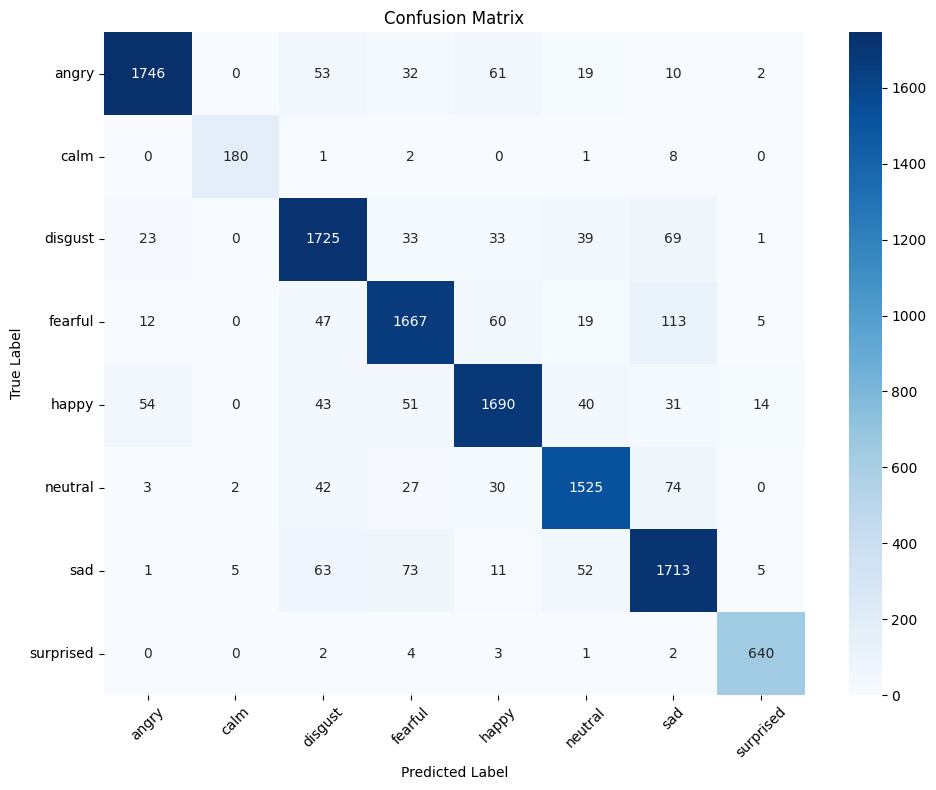

In [17]:
# 12. Evaluate & report with Train / Val / Test splits

from tensorflow.keras.models import load_model

# Train accuracy
train_loss, train_acc = model.evaluate(x_tr_cnn, y_train, verbose=0)
print(f"Train Accuracy:      {train_acc:.4f}")

# Validation accuracy
val_loss, val_acc = model.evaluate(x_val_cnn, y_val, verbose=0)
print(f"Validation Accuracy: {val_acc:.4f}")

# Test accuracy (best‐saved model)
best_model = load_model('best_model.keras')
test_loss, test_acc = best_model.evaluate(x_te_cnn, y_test, verbose=0)
print(f"Test Accuracy:       {test_acc:.4f}")

# Predictions on test set
y_pred_probs = best_model.predict(x_te_cnn, verbose=0)
y_pred       = np.argmax(y_pred_probs, axis=1)
y_true       = np.argmax(y_test,         axis=1)

# Confusion Matrix & Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(
    y_true, y_pred,
    target_names=encoder.categories_[0]
))

# Plot confusion matrix
cm     = confusion_matrix(y_true, y_pred)
labels = encoder.categories_[0]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


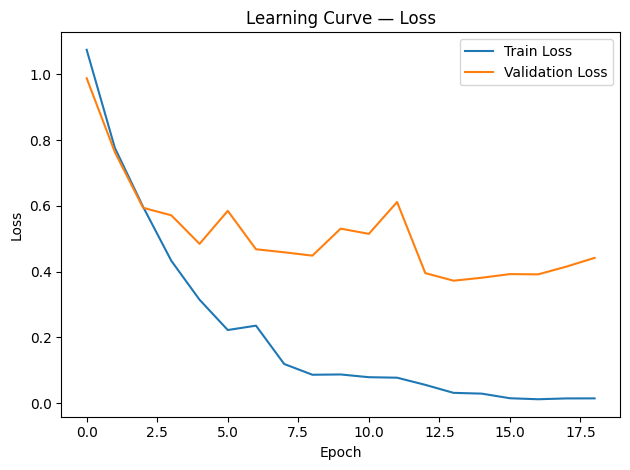

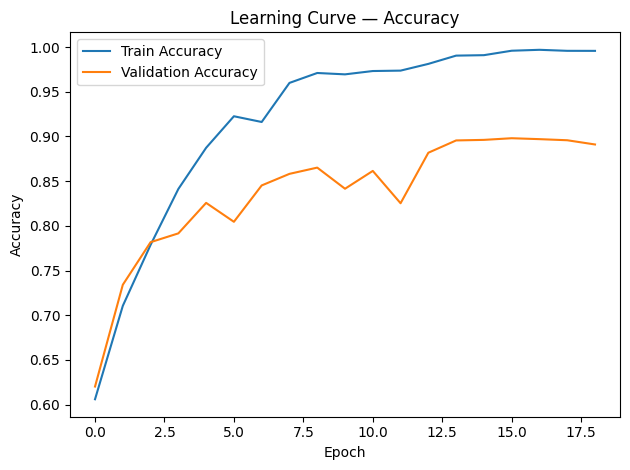

In [18]:
# 13. Load best model & history to visualize learning curves (Train vs. Validation)

from tensorflow.keras.models import load_model
import pickle
import matplotlib.pyplot as plt

# load the best‐saved model (if you ever want to re‑evaluate it)
best_model = load_model('best_model.keras')

# load training history (which used x_tr_cnn / x_val_cnn)
with open('history.pkl', 'rb') as f:
    hist = pickle.load(f)

# Plot Loss curve
plt.figure()
plt.plot(hist['loss'],      label='Train Loss')
plt.plot(hist['val_loss'],  label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve — Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Accuracy curve
plt.figure()
plt.plot(hist['accuracy'],      label='Train Accuracy')
plt.plot(hist['val_accuracy'],  label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve — Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
